In [158]:
import pickle
from collections import Counter
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, GaussianDropout, AveragePooling2D, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, PReLU, ELU
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import Activation
from tensorflow.keras.utils import plot_model

# 1. Preparación de datos


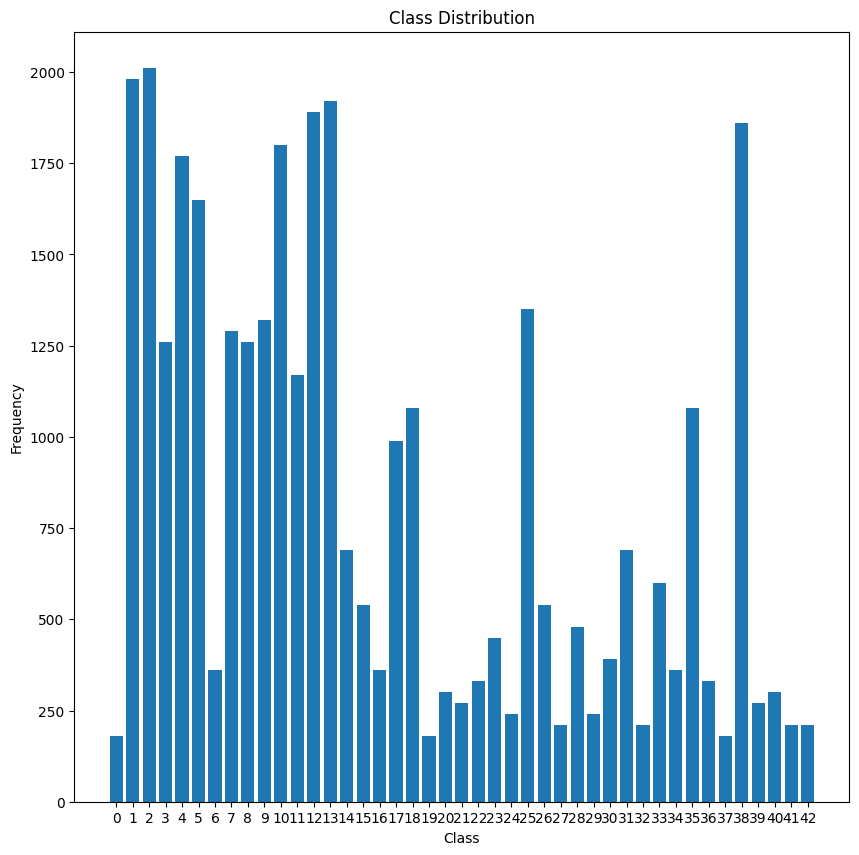

In [159]:
# 1.1 Descargar y descomprimir el dataset
with open('entrenamiento.p', 'rb') as file:
    loaded_data = pickle.load(file)

classes = len(np.unique(loaded_data["labels"]))
unique, counts = np.unique(loaded_data["labels"], return_counts=True)

coefficients = np.array([0.299, 0.587, 0.114])

grayscale_image_array = np.dot(loaded_data["features"], coefficients).astype(np.uint8)
grayscale_image_array = grayscale_image_array.astype(np.float64)

# Graficar la distribución de las clases
plt.figure(figsize=(10, 10))
plt.bar(unique, counts, tick_label=unique)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

# 1.2 Dividir el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(grayscale_image_array, loaded_data["labels"], test_size=0.2, random_state=42)

# 1.3 Preprocesamiento de los datos
X_train_reshaped = X_train.reshape(X_train.shape[0], 32, 32, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 32, 32, 1)

X_train = X_train_reshaped
X_test = X_test_reshaped

X_train = tf.cast(X_train, tf.int16)
X_test = tf.cast(X_test, tf.int16)
y_train = tf.cast(y_train, tf.int16)
y_test = tf.cast(y_test, tf.int16)

# 2. Implementación de la arquitectura LeNet
El Modelo LeNet es el pionero de las redes neuronales convolucionales, diseñada por Yann LeChun. Estan diseñadas para el análisis de imágenes y poder reconocerlas, especilamente de imágenes de 32x32 pixéles

## Arquitectura
- Capa de Input. El input cada modelo de LeNet utiliza una escala de grises para la imagén, donde cad auna es de tamaño 32*32.
- Primera capa Convolucional. Se aplican filtros convoluciones a las inputs. Esto es principalmente hecho para extraer esquinas, aristas y limitaciones de textura por la computación. Usualmente son 6.
- Primera capa de Pooling. La capa de Pooling hace más pequeña las dimensión de los mapas, para ayudar a hacer robusta la red neuronal.
- Segunda capa Convolucional. Más filtros se realizon después del primer pooling, y más grande los mapas previamente. analizando feautures a grandes rasgos en estos casos
- Segunda capa de Pooling. Sigue reduciendo más las imagenes y haciendo más robusta la red.
- Flattening: El resultado anterior se convierte un arreglo de una dimensión para poder analizar más.
- Hidden Connected Layers: Estas son similares a las redes neuronales normales, para analizar y después combinar feautres para tomar decisiones.
- Capa de Salida: La capa final hace las preddiciones finales, basandose en las clases disponibles. 

## Definición de Funciones
- Convolución. Se utiliza un filtro, o kernel, para la entrada, donde se utiliza una multiplicación para cada elemento y entradas, por ejemplo en una imagén, los pixles alreadedor de un pixel. Esto permite a la red detectar caractesticas como bordes o texturas para la red.

- Pooling. Esta sirve para reducir las dimensiones las caracterisitcas, al mismo tiempo guardando la información imporante. Ayuda a reducir la complejidad de la red y la invarianza también, ya que es menos factible que cambie por detalles, como los números por ejemplo. En otras paalabras, ayuda a evitar overfitting. 

- Función de Activación. Operación apliacada para cada elemento en la salidad de una neurona. Ayuda para poder aprender a la neurona debido a su no linealidad. En otras palabras, ayuda a decir si se activa una neurona o no. 

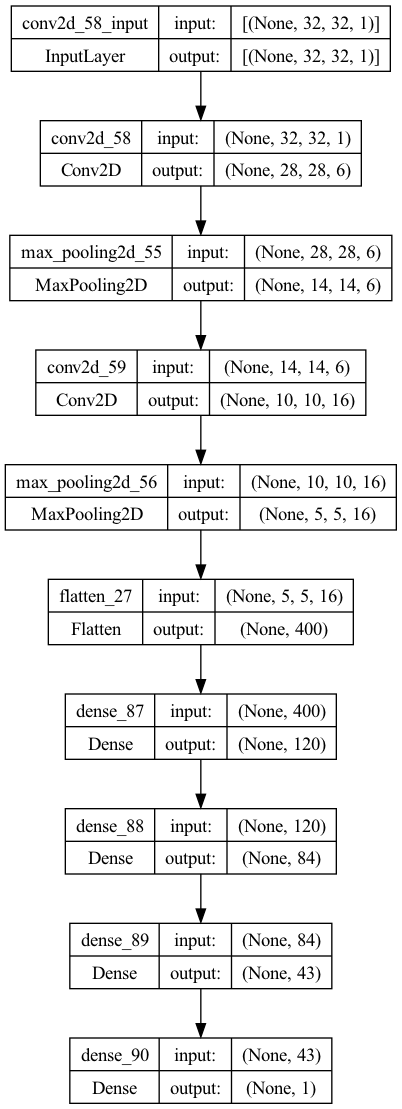

In [160]:
def weighted_categorical_crossentropy(y_true, y_pred):
    weights = tf.gather(class_weights, y_true)
    unweighted_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)
    weighted_loss = unweighted_loss * weights
    return weighted_loss

model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
    
model.add(Flatten())
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(classes, activation='softmax'))
model.add(Dense(1, activation='softmax'))

# 2.2 Mostrar el diseño de la red
plot_model(model, to_file = 'grafica_modelo.png', show_shapes = True, show_layer_names = True)

# 3. Construcción del modelo

## Estructura de capas
- Capas convolucionales. Se utilizan para extraer características de la imagen, como bordes, texturas, etc.
- Capas de pooling. Se utilizan para reducir la dimensionalidad de la imagen, y hacer más robusta la red.
- capas de fully connected. Se utilizan para poder combinar las características extraidas de la imagen, y poder hacer predicciones.

## Importancia de la función de perdida y el optimizador

La importancia de la función de perdida es que nos ayuda a saber que tan bien esta funcionando nuestro modelo, ya que nos dice que tan lejos esta de la respuesta correcta. En este caso, se utiliza la función de perdida de entropía cruzada, ya que es una función que se utiliza para clasificación de múltiples clases.

La importancia del optimizador es que nos ayuda a minimizar la función de perdida, y en este caso se utiliza el optimizador Adam, ya que es un optimizador que se utiliza para redes neuronales, y es un optimizador que se utiliza para problemas de clasificación.

In [161]:
total_samples = loaded_data["labels"].shape[0]
class_weights = np.array([total_samples / count for count in class_frequencies.values()])
class_weights = tf.constant(class_weights, dtype=tf.float32)
learning_rate = 0.001

model.compile(optimizer=optimizer, loss=weighted_categorical_crossentropy, metrics=['accuracy'])

# 4. Entrenamiento del modelo

## Explicación del proceso de entrenamiento

El proceso de entrenamiento consiste en alimentar a la red con datos de entrenamiento, y que la red pueda aprender de estos datos, y poder hacer predicciones. En este caso, se utilizan 10 épocas y un batch size de 128, ya que es un número que se utiliza comúnmente para entrenar redes neuronales.

In [162]:
# 4.3 Definir hiperparámetros
epochs = 10
batch_size = 128

# Entrenar el modelo
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/10


/Users/ls/miniconda/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)
/Users/ls/miniconda/lib/python3.10/site-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


InvalidArgumentError: No OpKernel was registered to support Op 'GatherV2' used by {{node weighted_categorical_crossentropy/GatherV2}} with these attrs: [Taxis=DT_INT32, batch_dims=0, Tparams=DT_FLOAT, Tindices=DT_INT16]
Registered devices: [CPU, GPU]
Registered kernels:
  device='XLA_CPU_JIT'; Taxis in [DT_INT32, DT_INT64]; Tindices in [DT_INT32, DT_INT16, DT_INT64]; Tparams in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT16, 930109355527764061, DT_HALF, DT_UINT32, DT_UINT64, DT_FLOAT8_E5M2, DT_FLOAT8_E4M3FN]
  device='GPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_INT32]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_INT32]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT64]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT64]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT64]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT64]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT32]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT32]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT32]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT32]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_HALF]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_HALF]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_BFLOAT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_BFLOAT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_DOUBLE]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_DOUBLE]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_COMPLEX64]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_COMPLEX64]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_COMPLEX128]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_COMPLEX128]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_BOOL]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_BOOL]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_STRING]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_STRING]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_RESOURCE]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_RESOURCE]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_VARIANT]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_VARIANT]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QINT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QINT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QUINT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QUINT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QINT32]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QINT32]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QUINT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QUINT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QINT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QINT16]; Tindices in [DT_INT64]

	 [[weighted_categorical_crossentropy/GatherV2]] [Op:__inference_train_function_10326]

# 5. Evaluación del modelo

In [ ]:
# Evaluación del modelo con el conjunto de prueba
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Calculo de precision
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = np.argmax(y_test, axis=1)
print("Precision: ", r2_score(y_test, y_pred))

# Calculo de recall
print("Recall: ", mean_squared_error(y_test, y_pred))

# Calculo de f1-score
print("F1-score: ", mean_absolute_error(y_test, y_pred))

# 6. Mejoras y experimentación

## Posibles mejoras
- Aumentar el número de épocas. Esto puede ayudar a que la red pueda aprender más de los datos, y poder hacer mejores predicciones.
- Aumentar el número de capas convolucionales. Esto puede ayudar a que la red pueda extraer más características de la imagen, y poder hacer mejores predicciones.
- Aumentar el número de capas de pooling. Esto puede ayudar a que la red pueda reducir más la dimensionalidad de la imagen, y poder hacer mejores predicciones.
- Aumentar el número de capas fully connected. Esto puede ayudar a que la red pueda combinar más características de la imagen, y poder hacer mejores predicciones.
- Aumentar el número de filtros en las capas convolucionales. Esto puede ayudar a que la red pueda extraer más características de la imagen, y poder hacer mejores predicciones.

In [ ]:
# Implementar mejoras en el modelo
improvedModel = Sequential()

improvedModel.add(Conv2D(6, kernel_size=(5, 5), activation='relu', input_shape=(32,32,3)))
improvedModel.add(MaxPooling2D(pool_size=(2, 2)))
improvedModel.add(Conv2D(16, kernel_size=(5, 5), activation='relu'))
improvedModel.add(MaxPooling2D(pool_size=(2, 2)))
improvedModel.add(Conv2D(120, kernel_size=(5, 5), activation='relu'))
improvedModel.add(MaxPooling2D(pool_size=(2, 2)))
improvedModel.add(Flatten())
improvedModel.add(Dense(84, activation='relu'))
improvedModel.add(Dense(classes, activation='softmax'))

improvedModel.compile(optimizer=optimizer, loss=weighted_categorical_crossentropy, metrics=['accuracy'])

improvedModel.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

# Evaluación del modelo con el conjunto de prueba
test_loss, test_acc = improvedModel.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

# Calculo de precision
y_pred = improvedModel.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
print("Precision: ", r2_score(y_test, y_pred))

# Calculo de recall
print("Recall: ", mean_squared_error(y_test, y_pred))

# Calculo de f1-score
print("F1-score: ", mean_absolute_error(y_test, y_pred))